In [ ]:
!pip install datasets

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
os.environ["WANDB_DISABLED"] = "true"


# --- Load & Filter Data ---

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/final/medical_final_withId.csv')
min_samples = 90
df = df.groupby('Specialty').filter(lambda x: len(x) >= min_samples)

# Encode labels


In [ ]:
y_encoder = LabelEncoder()
df['label'] = y_encoder.fit_transform(df['Specialty'])
num_labels = len(y_encoder.classes_)

# Train/Val/Test split


In [ ]:
train_df, test_df = train_test_split(
    df[['tokenized_text','label']], test_size=0.2, stratify=df['label'], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.25, stratify=train_df['label'], random_state=42
)

# Convert to HuggingFace Dataset


In [ ]:
hf_train = Dataset.from_pandas(train_df.rename(columns={'tokenized_text':'text'}))
hf_val   = Dataset.from_pandas(val_df.rename(columns={'tokenized_text':'text'}))
hf_test  = Dataset.from_pandas(test_df.rename(columns={'tokenized_text':'text'}))

# --- Tokenization ---


In [ ]:
model_name = 'pritamdeka/S-PubMedBert-MS-MARCO'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_batch(batch):
    return tokenizer(batch['text'], truncation=True, max_length=256)

hf_train = hf_train.map(tokenize_batch, batched=True)
hf_val   = hf_val.map(tokenize_batch, batched=True)
hf_test  = hf_test.map(tokenize_batch, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/11151 [00:00<?, ? examples/s]

Map:   0%|          | 0/3718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3718 [00:00<?, ? examples/s]

# Set format to PyTorch


In [ ]:
hf_train.set_format(type='torch', columns=['input_ids','attention_mask','label'])
hf_val.set_format(type='torch', columns=['input_ids','attention_mask','label'])
hf_test.set_format(type='torch', columns=['input_ids','attention_mask','label'])

# --- Model & Training ---


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pritamdeka/S-PubMedBert-MS-MARCO and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Setup TrainingArguments (without incompatible eval flags)
 Note: For in-training evaluation and saving best model, upgrade transformers (`pip install -U transformers>=4.5.0`).


In [ ]:
training_args = TrainingArguments(
    output_dir='./sbert_finetuned',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Compute metrics callback


In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# Trainer

In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-12-8bb5de1e2078>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Fine-tune (no in-training eval)


In [ ]:
trainer.train()

Step,Training Loss
100,2.039300
200,1.211800
300,1.038100
400,0.885700
500,0.832900
600,0.826700
700,0.778900
800,0.776700
900,0.740300
1000,0.722800


TrainOutput(global_step=5576, training_loss=0.5765006514840694, metrics={'train_runtime': 1196.6171, 'train_samples_per_second': 37.275, 'train_steps_per_second': 4.66, 'total_flos': 2857286181407508.0, 'train_loss': 0.5765006514840694, 'epoch': 4.0})

# --- Evaluation on Test Set ---


In [ ]:
metrics = trainer.evaluate(hf_test)
print(metrics)

{'eval_loss': 0.7190456986427307, 'eval_accuracy': 0.8125336202259279, 'eval_precision': 0.8065239811434397, 'eval_recall': 0.8125336202259279, 'eval_f1': 0.8067389819066461, 'eval_runtime': 31.5984, 'eval_samples_per_second': 117.664, 'eval_steps_per_second': 7.374, 'epoch': 4.0}


# --- Confusion Matrix & Report ---


                                  precision    recall  f1-score   support

                      Cardiology       0.78      0.80      0.79        90
                       Dentistry       0.89      0.93      0.91       136
                     Dermatology       0.81      0.88      0.85       254
             ENT and Pulmonology       0.61      0.73      0.67        75
                   Endocrinology       0.55      0.63      0.59        49
                 Family Medicine       0.92      0.80      0.86       356
                Gastroenterology       0.41      0.33      0.36        43
                General Medicine       0.80      0.77      0.79       455
               Internal Medicine       0.41      0.35      0.38       318
                       Neurology       0.86      0.92      0.89       247
       Obstetrics and Gynecology       0.93      0.96      0.95       926
                   Ophthalmology       0.92      0.96      0.94        68
    Orthopedics and Traumatology     

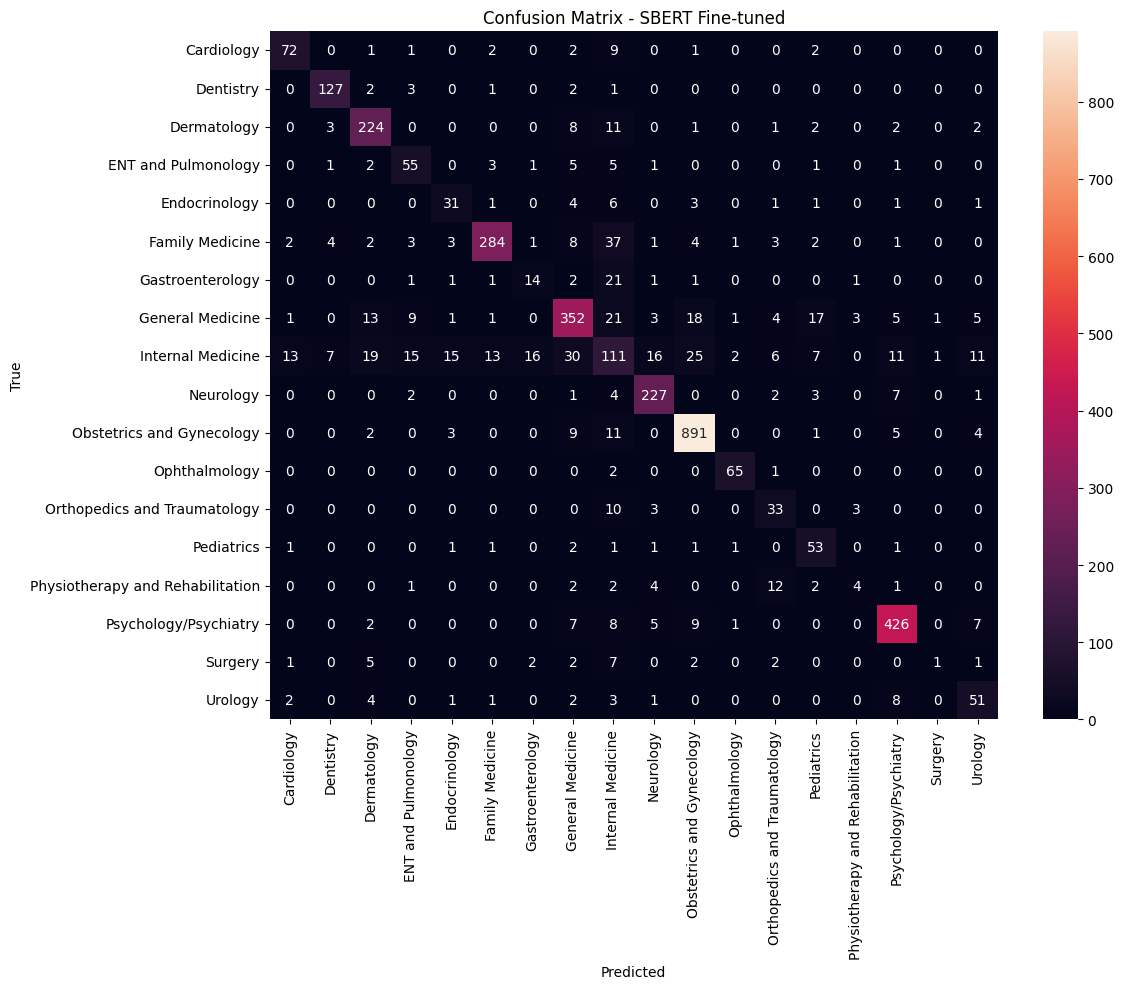

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_preds = trainer.predict(hf_test)
preds = np.argmax(test_preds.predictions, axis=1)
labels = test_preds.label_ids

print(classification_report(labels, preds, target_names=y_encoder.classes_))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SBERT Fine-tuned')
plt.tight_layout()
plt.show()